In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

print('Libraries Loaded')

Libraries Loaded


In [6]:
def getClassName(classID, cats):
    ids =[]
    for i in range(len(cats)):
        if cats[i]['supercategory']==classID:
            ids.append(cats[i]['id'])
    return "None" if len(ids)==0 else ids

def read_imgs(path):
    path_old = os.getcwd()

In [11]:
# dataDir='./COCOdataset2017'
# dataType='val'
# annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
src = r'C:\Users\saad\Desktop\Image-Background-Removal\COCO Dataset\COCOdataset2017'
ann = r'annotations'
imgs = r'images\\val'
dataType = r'instances_val.json'
annFile = os.path.join(src,ann,dataType)


# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
# print(cats)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


In [12]:
print('The class name is', getClassName('person', cats))

The class name is [1]


Number of images containing all the  classes: 2693


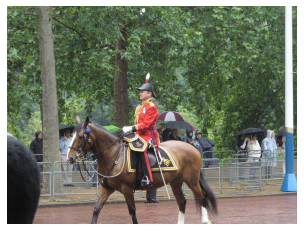

In [13]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
temp = img['file_name']
I = io.imread(os.path.join(src,imgs,temp))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

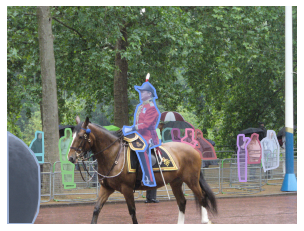

In [14]:
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [22]:
########## ALl POSSIBLE COMBINATIONS ########
classes = ['person']

images = []
if classes!=None:
    # iterate for each individual class in the list
    for className in tqdm(classes):
        # get all images containing given class
        catIds = coco.getCatIds(catNms=className)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
else:
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    
# Now, filter out the repeated images    
unique_images = []
for i in tqdm(range(len(images)),desc='Image Segregation'):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Image Segregation: 100%|████████████████████████████████████████████████████████| 2693/2693 [00:00<00:00, 10458.39it/s]

Number of images containing the filter classes: 2693


In [30]:
unique_images[0]

{'license': 3,
 'file_name': '000000532481.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000532481.jpg',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-20 16:28:24',
 'flickr_url': 'http://farm7.staticflickr.com/6048/5915494136_da3cfa7c5a_z.jpg',
 'id': 532481}

TypeError: Image data of dtype object cannot be converted to float

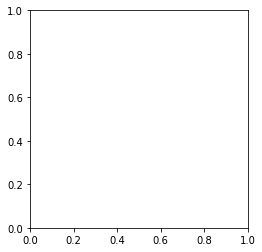

In [29]:
plt.imshow(unique_images[0])

In [31]:
annIds = coco.getAnnIds(unique_images[0]['id'], catIds=catIds, iscrowd=None)
print(annIds)

[508910, 2021158]


In [34]:
a = coco.loadAnns(annIds)
len(a)

2

In [46]:
path_old = os.getcwd()
os.chdir(os.path.join(src,imgs))
I = io.imread(images[0]['file_name'])


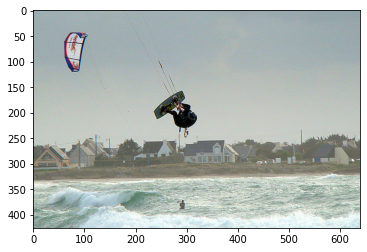

In [47]:
plt.imshow(I)

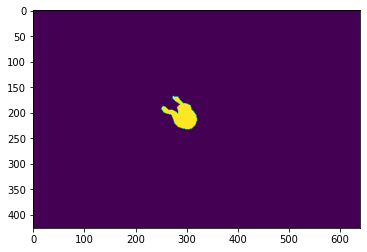

In [42]:
plt.imshow(np.minimum(coco.annToMask(a[0])*255, np.ones((426,640))))

In [ ]:
plt.imshow(coco.loadImunique_images[0])

In [44]:
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)

In [45]:
images

[{'license': 3,
  'file_name': '000000532481.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000532481.jpg',
  'height': 426,
  'width': 640,
  'date_captured': '2013-11-20 16:28:24',
  'flickr_url': 'http://farm7.staticflickr.com/6048/5915494136_da3cfa7c5a_z.jpg',
  'id': 532481},
 {'license': 1,
  'file_name': '000000458755.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000458755.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-16 23:06:51',
  'flickr_url': 'http://farm6.staticflickr.com/5119/5878453277_eea657a01d_z.jpg',
  'id': 458755},
 {'license': 1,
  'file_name': '000000385029.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000385029.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-21 05:40:19',
  'flickr_url': 'http://farm5.staticflickr.com/4061/4670536748_8c7bd89494_z.jpg',
  'id': 385029},
 {'license': 4,
  'file_name': '000000311303.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/00000

In [ ]:
#### GENERATE A BINARY MASK ####
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)

In [ ]:
np.unique(mask)

In [ ]:
folder = src
classes = ['person']

images_train, dataset_size_train, coco_train = filterDataset(folder, classes, 'train')
images_val, dataset_size_val, coco_val = filterDataset(folder, classes, 'val')

In [ ]:
batch_size = 32
input_image_size = (224,224)
mask_type = 'binary'

train_gen = dataGeneratorCoco(images_train, classes, coco_train, src,
                            input_image_size, batch_size, 'train', mask_type)

print("completed the train gen")

val_gen = dataGeneratorCoco(images_val, classes, coco_val, src,
                            input_image_size, batch_size, 'val', mask_type)

print('Completed the val gen')

In [ ]:
visualizeGenerator(train_gen)

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

train_aug_gen = augmentationsGenerator(train_gen, augGeneratorArgs,seed=42)
val_aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs,seed=42)

In [ ]:
visualizeGenerator(train_aug_gen)

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

n_epochs = 1

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size

in1 = Input(shape=(224,224, 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
segmentation = Conv2D(2,(1, 1),activation='sigmoid', name='seg')(conv7)

model = Model(inputs=[in1], outputs=[segmentation])

losses = {'seg': 'binary_crossentropy'
    }

metrics = {'seg': ['acc']
        }
model.compile(optimizer="adam", loss = losses, metrics=metrics)

model.summary()


# Start the training process
history = model.fit(x = train_aug_gen,
                validation_data = val_aug_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose = True)

In [ ]:
tester = getImage(images_val[6], os.path.join(src,'images\\val'), input_image_size)

In [ ]:
plt.imshow(tester)

In [ ]:
masker = getBinaryMask(images_val[6], coco_val, catIds, input_image_size)
masker.shape

In [ ]:
plt.imshow(masker)

In [ ]:
p = model.predict(np.expand_dims(tester,axis=0))

In [ ]:
px = p[0,:,:,:1]

px.shape

In [ ]:
plt.imshow(px)

In [ ]:
pa = np.copy(px)
pa[pa>=0.5]=1
pa[pa<0.5]=0

In [ ]:
np.unique(pa)

In [ ]:
plt.imshow(pa)

In [ ]:
pa.shape

In [ ]:
b = np.dstack([pa]*3)
b.shape

In [ ]:
def make_blur(img):
    # image = cv2.imread(img)
    ksize = (30, 30)
    blur = cv2.blur(img, ksize)
    return blur

def mask_blur(original_img, blur_img, predicted_img):
    # print("Shape: ", original_img.shape, blur_img.shape, predicted_img.shape)
    # cv2.imshow('img', predicted_img)
    # cv2.waitKeyEx(0)

    blue_channel_ori = original_img[:, :, 0]
    green_channel_ori = original_img[:, :, 1]
    red_channel_ori = original_img[:, :, 2]

    blue_channel_blr = blur_img[:, :, 0]
    green_channel_blr = blur_img[:, :, 1]
    red_channel_blr = blur_img[:, :, 2]

    blue_channel_pre = predicted_img[:, :, 0]
    green_channel_pre = predicted_img[:, :, 1]
    red_channel_pre = predicted_img[:, :, 2]

    new_b = []
    new_g = []
    new_r = []

    mks_img_new = np.zeros([224,224, 3])

    for i in range(3):
        if i == 0:
            img = blue_channel_blr
            msk = blue_channel_pre
            ori = blue_channel_ori
        if i == 1:
            img = green_channel_blr
            msk = green_channel_pre
            ori = green_channel_ori
        if i == 2:
            img = red_channel_blr
            msk = red_channel_pre
            ori = red_channel_ori

        if i == 0:
            new = new_b
        if i == 1:
            new = new_g
        if i == 2:
            new = new_r

        img = img.reshape(1, -1)[0]
        msk = msk.reshape(1, -1)[0]
        ori = ori.reshape(1, -1)[0]

        for k, m, o in zip(img, msk, ori):
            if int(m*255.) < 50:
                new.append(k)
            else:
                new.append(o)

        if i == 0:
            new_b = np.array(new_b).reshape(224, 224)
            mks_img_new[:, :, 0] = new_b
        if i == 1:
            new_g = np.array(new_g).reshape(224, 224)
            mks_img_new[:, :, 1] = new_g
        if i == 2:
            new_r = np.array(new_r).reshape(224, 224)
            mks_img_new[:, :, 2] = new_r

    return mks_img_new


def create_img(original_img, predicted_img):
    blur_img = make_blur(original_img)
    img = mask_blur(original_img, blur_img, predicted_img)
    
    return img

In [ ]:
foo = create_img(tester,b)

In [ ]:
plt.imshow(foo)

In [ ]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in tqdm(range(len(images)),desc='Image Segregation'):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
#                 print('Using Binary masking')
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
#                 print('Using Normal masking')
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask
        
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()
    
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug